# Load in the data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import sklearn
#import warnings

df_feat = pd.read_csv('../data/Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_values.csv')
df_targ = pd.read_csv('../data/Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_labels.csv')
df = pd.concat([df_feat, df_targ], axis = 1)

In [2]:
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

NameError: name 'warnings' is not defined

In [130]:
# def get_feature_names(column_transformer):
#     """Get feature names from all transformers.
#     Returns
#     -------
#     feature_names : list of strings
#         Names of the features produced by transform.
#     """
#     # Remove the internal helper function
#     #check_is_fitted(column_transformer)
    
#     # Turn loopkup into function for better handling with pipeline later
#     def get_names(trans):
#         # >> Original get_feature_names() method
#         if trans == 'drop' or (
#                 hasattr(column, '__len__') and not len(column)):
#             return []
#         if trans == 'passthrough':
#             if hasattr(column_transformer, '_df_columns'):
#                 if ((not isinstance(column, slice))
#                         and all(isinstance(col, str) for col in column)):
#                     return column
#                 else:
#                     return column_transformer._df_columns[column]
#             else:
#                 indices = np.arange(column_transformer._n_features)
#                 return ['x%d' % i for i in indices[column]]
#         if not hasattr(trans, 'get_feature_names'):
#         # >>> Change: Return input column names if no method avaiable
#             # Turn error into a warning
#             warnings.warn("Transformer %s (type %s) does not "
#                                  "provide get_feature_names. "
#                                  "Will return input column names if available"
#                                  % (str(name), type(trans).__name__))
#             # For transformers without a get_features_names method, use the input
#             # names to the column transformer
#             if column is None:
#                 return []
#             else:
#                 return [name + "__" + f for f in column]

#         return [name + "__" + f for f in trans.get_feature_names()]
    
#     ### Start of processing
#     feature_names = []
    
#     # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
#     if type(column_transformer) == sklearn.pipeline.Pipeline:
#         l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
#     else:
#         # For column transformers, follow the original method
#         l_transformers = list(column_transformer._iter(fitted=True))
    
    
#     for name, trans, column, _ in l_transformers: 
#         if type(trans) == sklearn.pipeline.Pipeline:
#             # Recursive call on pipeline
#             _names = get_feature_names(trans)
#             # if pipeline has no transformer that returns names
#             if len(_names)==0:
#                 _names = [name + "__" + f for f in column]
#             feature_names.extend(_names)
#         else:
#             feature_names.extend(get_names(trans))
    
#     return feature_names

# Column investigation
Drop:
- id
- extraction_type, extraction_type_group, extraction_type_class - keep class?
- scheme_name (keep scheme_managment)
- payment (keep payment_type)
- quality_group? (water_quality has same info but more detailed)
- quantity_group (keep quantity)
- source_type (keep source/source_class - what is other?)
- waterpoint_type_group (keep waterpoint_type)
- region_code, distrit_code, ward, subvillage, lga (keep region, latitude, longitude)
    - first use these columns to fill in missing long/lat? (ie mean from district_code)
- num_private
- recorded_by

Confusing Columns:
- Management/management group seem different - keep?
- Turn amount_tsh into 0 and not 0?
- construction year missing values
    - make new column based on this - date recorded?
    - group into decades + unknown?
- Group funder into top 5 + other?
    - same for installer
    - same for scheme_management
    - wpt_name?
- Population - is 0 unknown or like, no nearby population..?
    - also maybe consider grouping into like, 100s or 1000s?
- Missing (recorded) info in: funder, installer, gps_height?, population?, construction_year

Feature Creation:
- Use date_recorded to make a month column? Season one?
- Use lga to make rural/urban/unknown before dropping?


In [2]:
df.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'id', 'status_group'],
      dtype='object')

In [3]:
df.extraction_type_class.value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

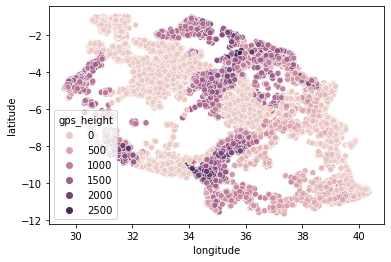

In [4]:
df2 = df[df['latitude'] != 0]
df3 = df2[df2['longitude'] != 0]
sns.scatterplot(x = df3['longitude'], y = df3['latitude'], hue = df3['gps_height'])
#Seems like aside from the 0s, other points seem reasonable

In [191]:
#Smaller dataset
df_trim = df.drop(columns = ['id', 'extraction_type', 'extraction_type_group', 'scheme_name',
                            'payment', 'quality_group', 'quantity_group', 'source_type', 'waterpoint_type_group',
                            'region_code', 'district_code', 'ward', 'subvillage', 'lga', 'num_private',
                            'recorded_by', 'funder', 'public_meeting'], axis = 1)

#Drop bad long/lat
df_trim = df_trim[df_trim['longitude'] != 0]
df_trim.columns

Index(['amount_tsh', 'date_recorded', 'gps_height', 'installer', 'longitude',
       'latitude', 'wpt_name', 'basin', 'region', 'population',
       'scheme_management', 'permit', 'construction_year',
       'extraction_type_class', 'management', 'management_group',
       'payment_type', 'water_quality', 'quantity', 'source', 'source_class',
       'waterpoint_type', 'status_group'],
      dtype='object')

In [192]:
df_trim['month'] = pd.DatetimeIndex(df_trim['date_recorded']).month
season = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'}
df_trim['season'] = df_trim['month'].map(season)
df_trim = df_trim.drop(columns = ['month'], axis = 1)


In [193]:
df_trim['permit'] = df_trim['permit'].fillna(value = False)

In [194]:
def decades(year):
    if year == 0:
        return 'Unknown'
    else:
        return str((year // 10) * 10)

df_trim['construction_year'] = df_trim['construction_year'].apply(decades)

# Missing values
- funder - 3,635 - fill with unknown
- installer - 3,655 - fill with unknown
- public_meeting - 3,334 - T/F... fill with median or unknown?
- scheme_management - 3877 - fill with unknown
- permit - 3056 - T/F... fill with median or unknown?

In [6]:
df_trim.isna().sum()

amount_tsh                  0
date_recorded               0
funder                   3635
gps_height                  0
installer                3655
longitude                   0
latitude                    0
wpt_name                    0
basin                       0
region                      0
population                  0
public_meeting           3334
scheme_management        3877
permit                   3056
construction_year           0
extraction_type_class       0
management                  0
management_group            0
payment_type                0
water_quality               0
quantity                    0
source                      0
source_class                0
waterpoint_type             0
status_group                0
dtype: int64

In [3]:
# long_mean = df_trim.groupby('region')['longitude'].mean()
# df_trim['longitude'] = df_trim.apply(
#     lambda row: long_mean[row['region']] if row['longitude'] == 0 else row['longitude'], axis=1)

In [8]:
# df_trim['funder'] = df_trim['funder'].fillna('Unknown')
# df_trim['installer'] = df_trim['installer'].fillna('Unknown')
# df_trim['scheme_management'] = df_trim['scheme_management'].fillna('Unknown')
# df_trim.isna().sum()

#funder, installer, sceme_management = Unknown
#permit, public_meeting = False
#longitude replace 0s w/ mean
#latitude replace -2e-8 with mean
#construction_year -> 0 = unknown and decades
#population -> ?

In [9]:
df_trim.describe()

,amount_tsh,gps_height,longitude,latitude,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000
mean,317.650385,668.297239,34.858990,-5.706033e+00,179.909983,1300.652475
std,2997.574558,693.116350,3.050968,2.946019e+00,471.482176,951.620547
min,0.000000,-90.000000,24.482637,-1.164944e+01,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,30500.000000,2013.000000


In [42]:
df_trim.status_group.value_counts()

functional                 31389
non functional             22268
functional needs repair     3931
Name: status_group, dtype: int64

# Pipeline Setup

In [43]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import MissingIndicator
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

"""
def long_replace(data):
    long_mean = data.groupby('region')['longitude'].mean()
    for idx, row in data.iterrows():
        longitude = row['longitude']
        if row['longitude'] == 0:
            longitude = long_mean[row['region']]
        data.at[idx,'longitude'] = longitude
    return data['longitude']
"""

#df_trim.status_group = df_trim.status_group.map({'functional' : 0, 'non functional': 1, 'functional needs repair': 1})
y = df_trim['status_group']
X = df_trim.drop(columns = ['status_group'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

X_train_cat1 = X_train.select_dtypes('object')
num_to_cat = X_train['construction_year']
X_train_cat = pd.concat([X_train_cat1, num_to_cat], axis = 1)
X_train_cont = X_train.select_dtypes(['float64', 'int64'])
X_train_cont = X_train_cont.drop(columns = ['construction_year'])


def decades(years):
    years = (years//10)*10
    return years.astype(str)

cat_impute = ColumnTransformer(transformers=[
    #Replace funder, installer, and scheme_management w/ unknown
    ("cat_impute", SimpleImputer(strategy='constant', fill_value = 'Unknown'), ["funder", "installer", "scheme_management"]),
    #Replace permit and public_meeting as false
    ('bool_impute', SimpleImputer(strategy='constant', fill_value = False), ["permit", "public_meeting"]),
    #construction_year change into decades + 0
    ('year_str', FunctionTransformer(decades), ['construction_year'])
    ], remainder="passthrough")

cont_impute = ColumnTransformer(transformers=[
    #Change 0s in longitude to avg and -2e-8 in latitude to avg
    ('long', SimpleImputer(missing_values = 0.0), ['longitude']),
    ('lat', SimpleImputer(missing_values = -2e-8), ['latitude'])
    ], remainder="passthrough")

continuous_pipeline = Pipeline(steps=[
    ('cont_imp', cont_impute),
    ('ss', StandardScaler())
])
                
categorical_pipeline = Pipeline(steps=[
    ('cat_imp', cat_impute),
    ('ohe', OneHotEncoder(drop='first',
                         sparse=False))
])

trans = ColumnTransformer(transformers=[
    ('continuous', continuous_pipeline, X_train_cont.columns),
    ('categorical', categorical_pipeline, X_train_cat.columns)
])

# Baseline Model

In [14]:
from sklearn.dummy import DummyClassifier

model_pipe = Pipeline(steps=[
    ('trans', trans),
    ('dummy', DummyClassifier(random_state = 42, strategy = 'most_frequent'))
])

model_pipe.fit(X_train, y_train)
model_pipe.score(X_train, y_train)

0.542334455667789

# First Basic Model

<AxesSubplot:>

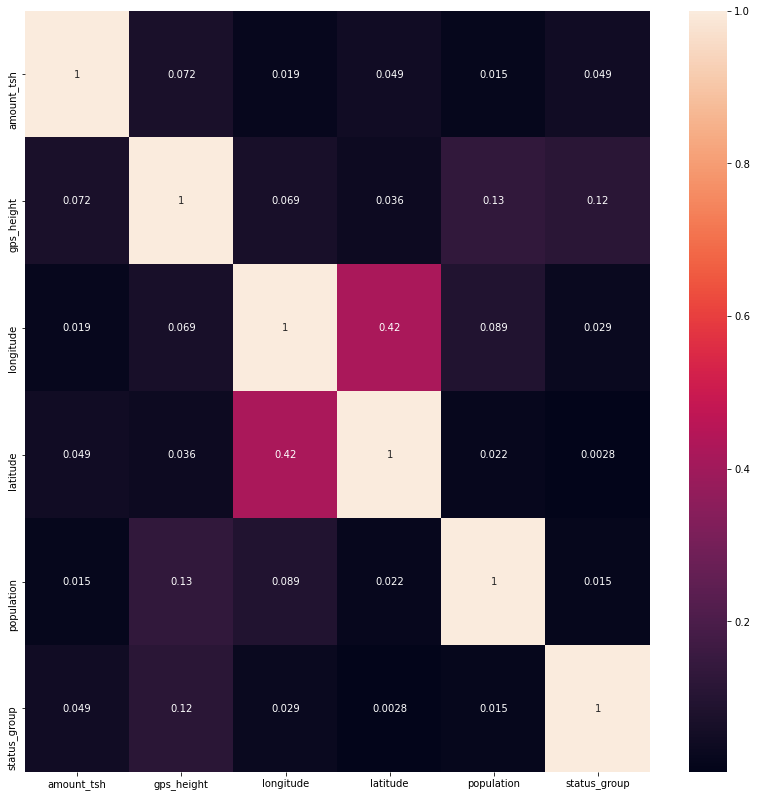

In [16]:
# with_target = pd.concat([X_train_cont, y_train], axis = 1)
# with_target
# fig, ax = plt.subplots(figsize=(14,14))
# sns.heatmap(with_target.corr().abs(), annot = True)

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score

X = df_trim[['gps_height', 'water_quality']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

continuous_pipeline = Pipeline(steps=[
    ('ss', StandardScaler())
])
                
categorical_pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first',
                         sparse=False))
])

trans = ColumnTransformer(transformers=[
    ('continuous', continuous_pipeline, ['gps_height']),
    ('categorical', categorical_pipeline, ['water_quality'])
])


simple_log = Pipeline(steps=[
    ('trans', trans),
    ('simple_log', LogisticRegression(random_state = 42))
])

simple_log.fit(X_train, y_train)
y_pred = simple_log.predict(X_train)
print(precision_score(y_train, y_pred))

0.6453586497890296


# Getting binning/long+lat functions to work

In [93]:
def update_with_train(X_train):
    #long_mean = X_train.groupby('region')['longitude'].mean()
    #lat_mean = X_train.groupby('region')['latitude'].mean()
    inst_top_five = df_trim.installer.value_counts(sort = True, ascending = False)[:5]
    inst_top_five_list = list(inst_top_five.index)
    for idx, value in enumerate(inst_top_five_list):
        inst_top_five_list[idx] = value.lower()
        
    sch_top_five = df_trim.scheme_management.value_counts(sort = True, ascending = False)[:5]
    sch_top_five_list = list(sch_top_five.index)
    for idx, value in enumerate(sch_top_five_list):
        sch_top_five_list[idx] = value.lower()
        
    fun_top_five = df_trim.funder.value_counts(sort = True, ascending = False)[:5]
    fun_top_five_list = list(fun_top_five.index)
    for idx, value in enumerate(fun_top_five_list):
        fun_top_five_list[idx] = value.lower() 
        
    return inst_top_five_list, sch_top_five_list, fun_top_five_list

"""
def long_replace(data):
    for idx, value in data['longitude'].iterrows():
        longitude = value
        if longitude == 0:
            #Need to figure out how to check rows region
            #longitude = long_mean[row['region']]
            data.at[idx, 'longitude'] = longitude
    return data

def lat_replace(data):
    for idx, value in data['latitude'].iterrows():
        latitude = value
        if latitude == -2e-8:
            #Need to figure out how to check rows region
            #latitude = lat_mean[row['region']]
            data.at[idx,'latitude'] = latitude
    return data
"""

"""def install_bin(data):
    for idx, value in data['installer'].items():
        inst = value
        if type(inst) == float:
            data.at[idx, 'installer'] = 'other'
        elif inst.lower() in inst_top_five_list:
            data.at[idx, 'installer'] = inst.lower()
        else:
            data.at[idx, 'installer'] = 'other'
    return data

def funder_bin(data):
    for idx, value in data['funder'].items():
        fund = value
        if type(fund) == float:
            data.at[idx, 'funder'] = 'other'
        elif fund.lower() in fun_top_five_list:
            data.at[idx, 'funder'] = fund.lower()
        else:
            data.at[idx, 'funder'] = 'other'
    return data

def scheme_bin(data):
    for idx, value in data['scheme_management'].items():
        scheme = value
        if type(scheme) == float:
            data.at[idx, 'scheme_management'] = 'other'
        elif scheme.lower() in sch_top_five_list:
            data.at[idx, 'scheme_management'] = scheme.lower()
        else:
            data.at[idx, 'scheme_management'] = 'other'
    return data"""
    
X = df_trim.drop(columns = ['status_group'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
X_train_cat1 = X_train.select_dtypes('object')
num_to_cat = X_train['construction_year']
X_train_cat = pd.concat([X_train_cat1, num_to_cat], axis = 1)
X_train_cont = X_train.select_dtypes(['float64', 'int64'])
X_train_cont = X_train_cont.drop(columns = ['construction_year'], axis = 1)
inst_top_five_list, sch_top_five_list, fun_top_five_list = update_with_train(X_train)
X_train_cat.columns

group = ColumnTransformer(transformers=[
    #Bin installer
    ('inst', FunctionTransformer(install_bin), ['installer']),
    #Bin funder
    ('fund', FunctionTransformer(funder_bin), ['funder']),
    #Bin scheme_management
    ('scheme', FunctionTransformer(scheme_bin), ['scheme_management']),
    #Replace permit and public_meeting as false
    ('bool_impute', SimpleImputer(strategy='constant', fill_value = False), ["permit", "public_meeting"]),
    #construction_year change into decades + 0
    ('year_str', FunctionTransformer(decades), ['construction_year'])
    ], remainder="passthrough")


test = Pipeline(steps=[
    ('bin', group)
])
test.fit(X_train, y_train)
test_data = test.transform(X_train)
pd.DataFrame(test_data)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,dwe,danida,vwc,True,True,1980,2000,2013-02-20,1067,35.6035,...,handpump,vwc,user-group,on failure,soft,seasonal,shallow well,groundwater,hand pump,Winter
1,dwe,other,water authority,False,True,2000,500,2013-01-16,1165,30.4218,...,handpump,vwc,user-group,on failure,soft,enough,shallow well,groundwater,hand pump,Winter
2,dwe,government of tanzania,vwc,True,True,2000,0,2011-03-05,1224,38.3317,...,gravity,vwc,user-group,never pay,soft,enough,spring,groundwater,communal standpipe,Spring
3,other,other,wua,False,True,0,0,2011-04-15,0,33.864,...,gravity,wua,user-group,never pay,soft,seasonal,river,surface,communal standpipe,Spring
4,other,world bank,vwc,True,True,2010,0,2013-01-20,306,38.9573,...,other,vwc,user-group,never pay,soft,enough,machine dbh,groundwater,communal standpipe multiple,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43186,dwe,other,vwc,True,True,0,0,2011-07-17,0,31.3632,...,other,vwc,user-group,never pay,soft,enough,shallow well,groundwater,other,Summer
43187,other,other,vwc,True,True,2010,500,2011-03-17,1806,34.8072,...,gravity,vwc,user-group,monthly,soft,enough,spring,groundwater,communal standpipe,Spring
43188,dwe,other,vwc,True,True,1980,50,2011-02-25,91,38.8489,...,motorpump,vwc,user-group,per bucket,soft,insufficient,river,surface,communal standpipe,Winter
43189,other,other,vwc,False,True,0,50,2013-01-23,581,39.2799,...,gravity,wug,user-group,per bucket,soft,insufficient,spring,groundwater,communal standpipe multiple,Winter


# Let's Iterate Babyyyy

### First Simple Model

In [189]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score

X = df_trim[['gps_height', 'water_quality']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
X_train_cat = X_train.select_dtypes('object')
X_train_cont = X_train.select_dtypes(['float64', 'int64'])

continuous_pipeline = Pipeline(steps=[
    ('ss', StandardScaler())
])
                
categorical_pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first',
                         sparse=False))
])

trans = ColumnTransformer(transformers=[
    ('continuous', continuous_pipeline, X_train_cont.columns),
    ('categorical', categorical_pipeline, X_train_cat.columns)
])


simple_log = Pipeline(steps=[
    ('trans', trans),
    ('simple_log', LogisticRegression(random_state = 42))
])

simple_log.fit(X_train, y_train)
y_pred = simple_log.predict(X_train)
print(precision_score(y_train, y_pred))

0.6366596882996045


In [142]:
"""def impute_transform(X_train, y_train, X_test):
    imp_trans = ColumnTransformer(transformers=[
        #Bin installer
        ('inst', FunctionTransformer(install_bin), ['installer']),
        #Bin funder
        ('fund', FunctionTransformer(funder_bin), ['funder']),
        #Bin scheme_management
        ('scheme', FunctionTransformer(scheme_bin), ['scheme_management']),
        #Replace permit and public_meeting as false
        ('bool_impute', SimpleImputer(strategy='constant', fill_value = False), ["permit", "public_meeting"]),
        #construction_year change into decades + 0
        ('year_str', FunctionTransformer(decades), ['construction_year'])
        ], remainder="passthrough")
    
    imp_trans.fit(X_train, y_train)
    train = imp_trans.transform(X_train)
    test = imp_trans.transform(X_test)
    train_df = pd.DataFrame(train, columns = get_feature_names(imp_trans))
    test_df = pd.DataFrame(train, columns = get_feature_names(imp_trans))
    return train_df, test_df"""

In [167]:
def install_bin(entry):
    if type(entry) == float:
        return 'other'
    elif entry.lower() in inst_list:
        return entry.lower()
    else:
        return 'other'

def scheme_bin(entry):
    if type(entry) == float:
        return 'other'
    elif entry.lower() in scheme_list:
        return entry.lower()
    else:
        return 'other'

### All columns logreg

In [195]:
X = df_trim.drop(columns = ['status_group'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

inst_five = X_train.installer.value_counts(sort = True, ascending = False)[:5]
inst_list = list(inst_five.index)
for idx, value in enumerate(inst_list):
    inst_list[idx] = value.lower()
        
scheme_eight = X_train.scheme_management.value_counts(sort = True, ascending = False)[:9]
scheme_list = list(scheme_eight.index)
for idx, value in enumerate(scheme_list):
    scheme_list[idx] = value.lower() 

X_train['installer'] = X_train['installer'].apply(install_bin)
X_train['scheme_management'] = X_train['scheme_management'].apply(scheme_bin)

X_train_cat = X_train.select_dtypes('object')
X_train_cont = X_train.select_dtypes(['float64', 'int64'])

pipe_two = Pipeline(steps=[
    ('trans', trans),
    ('simple_log', LogisticRegression(random_state = 42))
])

pipe_two.fit(X_train, y_train)
y_pred = pipe.predict(X_train)
print(precision_score(y_train, y_pred))

0.6366596882996045


### All columns Decision Tree

In [198]:
from sklearn.tree import DecisionTreeClassifier

X = df_trim.drop(columns = ['status_group'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

inst_five = X_train.installer.value_counts(sort = True, ascending = False)[:5]
inst_list = list(inst_five.index)
for idx, value in enumerate(inst_list):
    inst_list[idx] = value.lower()
        
scheme_eight = X_train.scheme_management.value_counts(sort = True, ascending = False)[:9]
scheme_list = list(scheme_eight.index)
for idx, value in enumerate(scheme_list):
    scheme_list[idx] = value.lower() 

X_train['installer'] = X_train['installer'].apply(install_bin)
X_train['scheme_management'] = X_train['scheme_management'].apply(scheme_bin)

X_train_cat = X_train.select_dtypes('object')
X_train_cont = X_train.select_dtypes(['float64', 'int64'])

pipe_three = Pipeline(steps=[
    ('trans', trans),
    ('simple_log', DecisionTreeClassifier(criterion = 'entropy', random_state = 42))
])

pipe_three.fit(X_train, y_train)
y_pred = pipe_three.predict(X_train)
print(precision_score(y_train, y_pred))

0.7025925506622891


### All columns -gulp- ensemble

In [199]:
from xgboost import XGBClassifier

X = df_trim.drop(columns = ['status_group'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

inst_five = X_train.installer.value_counts(sort = True, ascending = False)[:5]
inst_list = list(inst_five.index)
for idx, value in enumerate(inst_list):
    inst_list[idx] = value.lower()
        
scheme_eight = X_train.scheme_management.value_counts(sort = True, ascending = False)[:9]
scheme_list = list(scheme_eight.index)
for idx, value in enumerate(scheme_list):
    scheme_list[idx] = value.lower() 

X_train['installer'] = X_train['installer'].apply(install_bin)
X_train['scheme_management'] = X_train['scheme_management'].apply(scheme_bin)

X_train_cat = X_train.select_dtypes('object')
X_train_cont = X_train.select_dtypes(['float64', 'int64'])

pipe_three = Pipeline(steps=[
    ('trans', trans),
    ('simple_log', XGBClassifier())
])

pipe_three.fit(X_train, y_train)
y_pred = pipe_three.predict(X_train)
print(precision_score(y_train, y_pred))

0.6436394271272114
